In [1]:
import warnings
import pandas as pd
import numpy as numpy
import sys, os

from causalinference import CausalModel

In [2]:
completed_df = pd.read_csv('../data/processeddata/completedrequests.csv')
df = pd.read_csv('../data/processeddata/mergeddata.csv')

In [3]:
completed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Trip ID           536020 non-null  int64  
 1   Trip Origin       536020 non-null  object 
 2   Trip Destination  536020 non-null  object 
 3   Trip Start Time   534369 non-null  object 
 4   Trip End Time     536019 non-null  object 
 5   datetime          536020 non-null  object 
 6   hour              536020 non-null  int64  
 7   is_weekend        536020 non-null  bool   
 8   Trip distance_km  536020 non-null  float64
 9   duration_hours    534368 non-null  float64
 10  speed_kmh         534368 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 41.4+ MB


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Trip ID                1557740 non-null  int64  
 1   Trip Origin            1557740 non-null  object 
 2   Trip Destination       1557740 non-null  object 
 3   Trip Start Time        1555718 non-null  object 
 4   Trip End Time          1557740 non-null  object 
 5   datetime               1557740 non-null  object 
 6   hour                   1557740 non-null  int64  
 7   is_weekend             1557740 non-null  bool   
 8   driver_id              1557740 non-null  int64  
 9   driver_action          1557740 non-null  object 
 10  Driver Location        1557740 non-null  object 
 11  driver_clientdistance  1557740 non-null  float64
 12  day_of_week            1557740 non-null  object 
 13  lat                    1557740 non-null  float64
 14  lon               

In [5]:
from geopy.distance import geodesic

In [6]:
df['Trip distance_km'] = df.apply(lambda row: geodesic((row['Trip Origin']), (row['Trip Destination'])).kilometers, axis=1)

In [7]:
df['Trip End Time'] = pd.to_datetime(df['Trip End Time'])
df['datetime'] = pd.to_datetime(df['datetime'])

In [8]:
df['duration_hours'] = df.apply(lambda row: (row['Trip End Time'] - row['datetime']).total_seconds() / 3600, axis=1)

df['speed_kmh'] = df['Trip distance_km'] / df['duration_hours']

split data 

In [9]:
from sklearn.model_selection import train_test_split

train_df, holdout_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt

# Define nodes and edges based on domain knowledge
nodes = ["Trip_ID", "Trip_Origin", "Trip_Destination", "Trip_Start_Time", "Trip_End_Time",
         "datetime", "hour", "is_weekend", "driver_id", "driver_action", "Driver_Location",
         "driver_clientdistance", "day_of_week", "lat", "lon", "date"]

edges = [("Trip_Start_Time", "Trip_End_Time"), ("datetime", "hour"), ("datetime", "date"),
         ("Trip_Origin", "Trip_Destination"), ("driver_id", "driver_action"), 
         ("driver_id", "Driver_Location"), ("Driver_Location", "driver_clientdistance"),
         ("Trip_Start_Time", "driver_action"), ("day_of_week", "is_weekend"), 
         ("lat", "Driver_Location"), ("lon", "Driver_Location"), ("Trip_Origin", "driver_action"),
         ("Trip_Destination", "driver_action"), ("driver_clientdistance", "driver_action"), 
         ("is_weekend", "driver_action"), ("hour", "driver_action")]

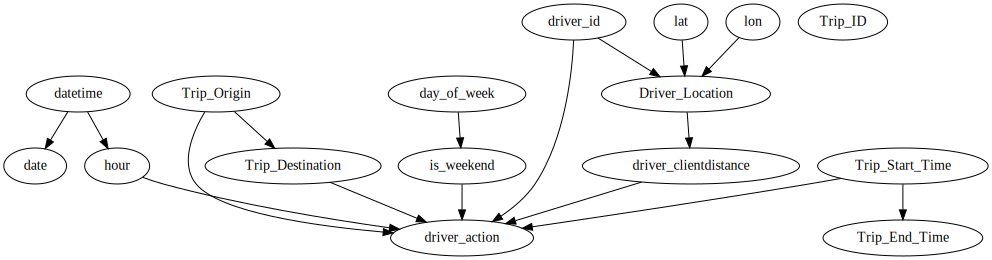

In [11]:
# Create the causal model
causal_model = CausalGraphicalModel(nodes=nodes, edges=edges)

causal_model.draw()

In [12]:
dsep2 = causal_model.is_d_separated("driver_action", "hour", {"datetime"})
print(f"Are 'driver_action' and 'hour' d-separated given 'datetime'? {dsep2}")

Are 'driver_action' and 'hour' d-separated given 'datetime'? False


In [13]:
from pgmpy.models import MarkovNetwork

mm = MarkovNetwork()

mm.add_nodes_from(nodes)
mm.add_edges_from(edges)

markov_blanket = mm.markov_blanket("driver_action")

markov_blanket_list = list(markov_blanket)
print(f"Markov blanket of 'driver_action': {markov_blanket_list}")

Markov blanket of 'driver_action': ['driver_id', 'Trip_Start_Time', 'Trip_Origin', 'Trip_Destination', 'driver_clientdistance', 'is_weekend', 'hour']


/home/grace-nyutu/Documents/Logistic_optimization/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create Causal Graphs and Compare with Ground Truth

In [14]:
fraction = 0.1
train_sample = train_df.sample(frac=fraction, random_state=42)

In [15]:
train_df.columns

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'datetime', 'hour', 'is_weekend', 'driver_id',
       'driver_action', 'Driver Location', 'driver_clientdistance',
       'day_of_week', 'lat', 'lon', 'date', 'Trip distance_km',
       'duration_hours', 'speed_kmh'],
      dtype='object')

# Interventions analysis with 'dowhy'

In [16]:
import numpy as np
from dowhy import CausalModel
from sklearn.metrics import jaccard_score
import networkx as nx

In [17]:
def create_unfulfilled_requests(row):
    if row['driver_action'] == 'rejected':
        return np.random.randint(1, 4)  # Randomly generate unfulfilled requests
    else:
        return 0  # Default value

# Apply function to create unfulfilled_requests column
train_df['unfulfilled_requests'] = train_df.apply(create_unfulfilled_requests, axis=1)

In [18]:
holdout_df['unfulfilled_requests'] = holdout_df.apply(create_unfulfilled_requests, axis=1)

In [19]:
from dowhy import CausalModel

# Define the interventions as new columns in your DataFrame
interventions = {
    "driver_clientdistance": 0.8,  # Knowing location of next 20% of orders within 5km accuracy
    "speed_kmh": 0.5,  # Moving 1km every 30 mins
    "duration_hour": 8,
    "num_drivers": 1.1  # Increase number of drivers by 10%
}

# # Ensure your DataFrame has these columns and values populated for the analysis
# train_df['driver_clientdistance'] = 0  # Default value
# train_df['speed_kmh'] = 0  # Default value
# train_df['duration_hours'] = 0  # Default value
# train_df['num_drivers'] = 1  # Default value

# # Update DataFrame with intervention values
# train_df.loc[:, 'driver_clientdistance'] = interventions['driver_clientdistance']
# train_df.loc[:, 'speed_kmh'] = interventions['speed_kmh']
# train_df.loc[:, 'duration_hours'] = interventions['duration_hours']
# train_df.loc[:, 'num_drivers'] = interventions['num_drivers']

# Perform causal analysis for each intervention
results = {}

for treatment in interventions.keys():
    model = CausalModel(
        data=train_df,
        treatment=[treatment],
        outcome='unfulfilled_requests',
        common_causes=['hour', 'day_of_week', 'is_weekend', 'driver_id', 'duration_hours']
    )
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching"
    )
    
    results[treatment] = causal_estimate.value

# Print results for each intervention
for treatment, estimate in results.items():
    print(f"Intervention on {treatment}: {estimate}")

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['driver_clientdistance'] on outcome ['unfulfilled_requests']
INFO:dowhy.causal_identifier:Causal effect can be identified.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
ERROR:dowhy.causal_estimator:Propensity score methods are applicable only for binary treatments


propensity_score_matching


Exception: Propensity score methods are applicable only for binary treatments

Train ML Models

In [ ]:
holdout_df.columns

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'datetime', 'hour', 'is_weekend', 'driver_id',
       'driver_action', 'Driver Location', 'driver_clientdistance',
       'day_of_week', 'lat', 'lon', 'date', 'Trip distance_km',
       'duration_hours', 'speed_kmh', 'unfulfilled_requests'],
      dtype='object')

In [ ]:
train_df = train_df.drop(['Trip Origin', 'Trip Start Time', 'Trip End Time', 'Trip Destination', 'Driver Location', 'datetime', 'date'], axis=1)

KeyError: "['Trip Origin', 'Trip Start Time', 'Trip End Time', 'Trip Destination', 'Driver Location'] not found in axis"

In [ ]:
holdout_df = holdout_df.drop(['Trip Origin', 'Trip Start Time', 'Trip End Time', 'Trip Destination', 'Driver Location', 'datetime', 'date'], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Using all variables
X_train = train_df.drop(columns=['unfulfilled_requests'])
y_train = train_df['unfulfilled_requests']
X_holdout = holdout_df.drop(columns=['unfulfilled_requests'])
y_holdout = holdout_df['unfulfilled_requests']

rf_all = RandomForestRegressor()
rf_all.fit(X_train, y_train)
xgb_all = XGBRegressor()
xgb_all.fit(X_train, y_train)

# Using selected variables
X_train_selected = train_df[direct_parents]
X_holdout_selected = holdout_df[direct_parents]

rf_selected = RandomForestRegressor()
rf_selected.fit(X_train_selected, y_train)
xgb_selected = XGBRegressor()
xgb_selected.fit(X_train_selected, y_train)

# Measure overfitting
def calculate_overfit(model, X_train, y_train, X_holdout, y_holdout):
    train_pred = model.predict(X_train)
    holdout_pred = model.predict(X_holdout)
    train_mse = mean_squared_error(y_train, train_pred)
    holdout_mse = mean_squared_error(y_holdout, holdout_pred)
    overfit_metric = train_mse - holdout_mse
    return overfit_metric

models = {
    "rf_all": rf_all,
    "xgb_all": xgb_all,
    "rf_selected": rf_selected,
    "xgb_selected": xgb_selected
}

overfitting_results = {name: calculate_overfit(model, X_train, y_train, X_holdout, y_holdout)
                       for name, model in models.items()}

print(overfitting_results)

TypeError: Cannot cast DatetimeArray to dtype float32

Formulate the Optimization Problem

In [ ]:
# Pseudo code for formulating the problem
# Using PuLP or similar library for optimization

from pulp import LpMaximize, LpProblem, LpVariable, lpSum

# Define the problem
prob = LpProblem("Driver_Placement_Optimization", LpMaximize)

# Define variables
driver_positions = LpVariable.dicts("DriverPosition", [(i, j) for i in range(n_drivers) for j in range(n_locations)], 0, 1, LpBinary)

# Define constraints and objective function
# ...

# Solve the problem
prob.solve()